# Dos & Ddos Attack Detection (BI LSTM Model)

In [18]:
# importing the Required Moudules

import os 
import math
import pandas as pd
import numpy as  np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler # type: ignore
from tensorflow.keras.models import Sequential, save_model, load_model, Model # type: ignore
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout # type: ignore
from tensorflow.keras.losses import MeanSquaredError # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error # type: ignore

# Data Preparation

In [19]:
# Loading the Data Sets
main_dataset = pd.read_csv(r'C:\Users\srika\OneDrive\Desktop\DeepNet\Data\ddos.csv')

In [22]:
# Remove leading and trailing spaces from column names
main_dataset.columns = main_dataset.columns.str.strip()
print(main_dataset.columns)

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [ ]:
# Select only the required features
selected_features = [
    'Flow Bytes/s', 'Flow Packets/s', 'Total Fwd Packets', 'Total Backward Packets',
    'Flow Duration', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 
    'Fwd IAT Mean', 'Fwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Max',
    'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
    'Min Packet Length', 'Max Packet Length', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
 
    'FIN Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count',
    'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
    'Active Mean', 'Active Std', 'Idle Mean', 'Idle Std'
]


targeted_feature = ["Label"]

dataset = main_dataset[selected_features]

targeted_dataset = main_dataset[targeted_feature]
# Convert the lable ddos to 1 and normal to 0
targeted_dataset["Label"] = targeted_dataset["Label"].apply(lambda x: 0 if x.lower() == "benign" else 1)

# Droping the row 1
dataset = dataset.drop(dataset.index[0])
targeted_dataset = targeted_dataset.drop(targeted_dataset.index[0])

C:\Users\srika\AppData\Local\Temp\ipykernel_10828\2334895686.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targeted_dataset["Label"] = targeted_dataset["Label"].apply(lambda x: 0 if x.lower() == "benign" else 1)


In [27]:
print(dataset.head(10))
print(dataset.count())
print(targeted_dataset.head(10))
print(targeted_dataset.count())

    Flow Bytes/s  Flow Packets/s  Total Fwd Packets  Total Backward Packets  \
1   1.100917e+05    18348.623850                  1                       1   
2   2.307692e+05    38461.538460                  1                       1   
3   3.529412e+05    58823.529410                  1                       1   
4   4.000000e+06   666666.666700                  2                       0   
5   1.174168e+04     1956.947162                  2                       0   
6   3.000000e+06   500000.000000                  2                       0   
7   2.857143e+05    47619.047620                  1                       1   
8   3.000000e+06   500000.000000                  2                       0   
9   9.250000e+06   500000.000000                  2                       0   
10  1.230000e+07   666666.666700                  2                       0   

    Flow Duration  Flow IAT Mean  Flow IAT Max  Flow IAT Min  Fwd IAT Mean  \
1             109          109.0           109      

In [28]:
print(dataset.head())
print(targeted_dataset.head())

   Flow Bytes/s  Flow Packets/s  Total Fwd Packets  Total Backward Packets  \
1  1.100917e+05    18348.623850                  1                       1   
2  2.307692e+05    38461.538460                  1                       1   
3  3.529412e+05    58823.529410                  1                       1   
4  4.000000e+06   666666.666700                  2                       0   
5  1.174168e+04     1956.947162                  2                       0   

   Flow Duration  Flow IAT Mean  Flow IAT Max  Flow IAT Min  Fwd IAT Mean  \
1            109          109.0           109           109           0.0   
2             52           52.0            52            52           0.0   
3             34           34.0            34            34           0.0   
4              3            3.0             3             3           3.0   
5           1022         1022.0          1022          1022        1022.0   

   Fwd IAT Max  ...  FIN Flag Count  URG Flag Count  CWE Flag Count 

# Cleaning the Data Set

In [29]:
# Checking Null Values
null_values = dataset.isnull().sum()
targeted_null_values = targeted_dataset.isnull().sum()
print("Null values in each column:\n", null_values)
print("Null values in each column:\n", targeted_null_values)

Null values in each column:
 Flow Bytes/s                   4
Flow Packets/s                 0
Total Fwd Packets              0
Total Backward Packets         0
Flow Duration                  0
Flow IAT Mean                  0
Flow IAT Max                   0
Flow IAT Min                   0
Fwd IAT Mean                   0
Fwd IAT Max                    0
Bwd IAT Mean                   0
Bwd IAT Max                    0
Packet Length Mean             0
Packet Length Std              0
Packet Length Variance         0
Min Packet Length              0
Max Packet Length              0
Total Length of Fwd Packets    0
Total Length of Bwd Packets    0
SYN Flag Count                 0
RST Flag Count                 0
PSH Flag Count                 0
ACK Flag Count                 0
FIN Flag Count                 0
URG Flag Count                 0
CWE Flag Count                 0
ECE Flag Count                 0
Init_Win_bytes_forward         0
Init_Win_bytes_backward        0
Active Mean   

In [31]:
# Replace infinity values with a large finite number

dataset[selected_features] = dataset[selected_features].replace([np.inf, -np.inf], np.nan)  # Replace inf with NaN
dataset[selected_features] = dataset[selected_features].fillna(dataset[selected_features].max())  # Replace NaN with max value in that column


# Data Normalization

In [32]:
# Normalize the Data for 6 features
scaler = MinMaxScaler()
dataset[selected_features] = scaler.fit_transform(dataset[selected_features])
dataset.head()

,Flow Bytes/s,Flow Packets/s,Total Fwd Packets,Total Backward Packets,Flow Duration,Flow IAT Mean,Flow IAT Max,Flow IAT Min,Fwd IAT Mean,Fwd IAT Max,...,FIN Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Init_Win_bytes_forward,Init_Win_bytes_backward,Active Mean,Active Std,Idle Mean,Idle Std
1,0.005817,0.403670,0.000000,0.00034,9.166671e-07,1.028037e-06,9.166667e-07,1.130841e-06,0.000000e+00,0.000000e+00,...,0.0,1.0,0.0,0.0,0.000458,0.003922,0.0,0.0,0.0,0.0
2,0.005875,0.407692,0.000000,0.00034,4.416669e-07,4.953271e-07,4.416667e-07,5.981308e-07,0.000000e+00,0.000000e+00,...,0.0,1.0,0.0,0.0,0.000458,0.003922,0.0,0.0,0.0,0.0
3,0.005933,0.411765,0.000000,0.00034,2.916668e-07,3.271028e-07,2.916667e-07,4.299065e-07,0.000000e+00,0.000000e+00,...,0.0,1.0,0.0,0.0,0.000488,0.005035,0.0,0.0,0.0,0.0
4,0.007685,0.533333,0.000518,0.00000,3.333335e-08,3.738318e-08,3.333333e-08,1.401869e-07,2.500000e-08,2.500000e-08,...,0.0,0.0,0.0,0.0,0.000504,0.000000,0.0,0.0,0.0,0.0
5,0.005769,0.400391,0.000518,0.00000,8.525004e-06,9.560748e-06,8.525000e-06,9.663550e-06,8.516667e-06,8.516667e-06,...,0.0,0.0,0.0,0.0,0.000504,0.000000,0.0,0.0,0.0,0.0


In [33]:
target_scaler = MinMaxScaler()
targeted_dataset['Label'] = target_scaler.fit_transform(targeted_dataset[['Label']])
targeted_dataset.head()

,Label
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0


# Creating Time Series Sequence & Splitinf the Data

In [35]:
# Function to create sequences
def create_sequences(column_data, time_steps):
    X, Y = [], []
    for i in range(len(column_data) - time_steps):
        X.append(column_data[i:i + time_steps])
        Y.append(column_data[i + time_steps])
    return np.array(X), np.array(Y).reshape(-1, 1)

# Define time steps (e.g., last 25 records to predict the next)
column_data = dataset[[
    'Flow Bytes/s', 'Flow Packets/s', 'Total Fwd Packets', 'Total Backward Packets',
    'Flow Duration', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 
    'Fwd IAT Mean', 'Fwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Max',
    'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
    'Min Packet Length', 'Max Packet Length', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
    'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
    'FIN Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count',
    'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
    'Active Mean', 'Active Std', 'Idle Mean', 'Idle Std'
]].values
time_steps = 15

X , _ = create_sequences(column_data, time_steps)

targeted_column = targeted_dataset['Label'].values
_ , y = create_sequences(targeted_column, time_steps)

print(f"Shape of X_Sequence: {X.shape}")
print(f"Values of X_Sequence: {X}")
print(f"Shape of y_Sequence: {y.shape}")
print(f"Values of y_Sequence: {y}")


Shape of X_Sequence: (225729, 15, 33)
Values of X_Sequence: [[[5.81656664e-03 4.03669725e-01 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [5.87452893e-03 4.07692308e-01 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [5.93320902e-03 4.11764706e-01 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [1.26320845e-02 6.00000000e-01 1.03573278e-03 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [5.76368876e-03 4.07407407e-01 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [5.76368876e-03 8.00000000e-01 5.17866390e-04 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[5.87452893e-03 4.07692308e-01 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [5.93320902e-03 4.11764706e-01 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [7.68491835e-03 5.33333333e-01 5.17866390e-04 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [5.76368876e-03

In [36]:
train_size = int(len(X)*0.90)
test_size = int(len(X)) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training data size: {train_size}, Testing data size: {test_size}")

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("Training X Values : ",X_train)
print("Testing X Values : ",X_test)
print("Training y Values : ",y_train)
print("Testing y Values : ",y_test)

Training data size: 203156, Testing data size: 22573
X_train shape: (203156, 15, 33)
X_test shape: (22573, 15, 33)
y_train shape: (203156, 1)
y_test shape: (22573, 1)
Training X Values :  [[[5.81656664e-03 4.03669725e-01 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [5.87452893e-03 4.07692308e-01 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [5.93320902e-03 4.11764706e-01 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [1.26320845e-02 6.00000000e-01 1.03573278e-03 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [5.76368876e-03 4.07407407e-01 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [5.76368876e-03 8.00000000e-01 5.17866390e-04 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[5.87452893e-03 4.07692308e-01 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [5.93320902e-03 4.11764706e-01 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+

# Functions to check the File Size 

In [37]:
def get_file_size(file_path):
  size = os.path.getsize(file_path)
  return size

In [38]:
def convert_bytes(size, unit=None):
  if unit == 'KB':
    return print(f'File Size is : {size / 1024:.2f} KB')
  elif unit == 'MB':
    return print(f'File Size is : {size / (1024 * 1024):.2f} MB')

# Model Cretation 

In [41]:
# Define the Bi-LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(75, return_sequences=True), input_shape=(time_steps, 33)))
model.add(Bidirectional(LSTM(75, return_sequences=False)))
model.add(Dense(75, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) # binary classification for attack or normal

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["accuracy"])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 15, 150)        │        65,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 150)            │       135,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,401 (829.69 KB)

 Trainable params: 212,401 (829.69 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.135)

Epoch 1/100
5492/5492 ━━━━━━━━━━━━━━━━━━━━ 123s 21ms/step - accuracy: 0.9890 - loss: 0.0091 - val_accuracy: 0.9939 - val_loss: 0.0059
Epoch 2/100
5492/5492 ━━━━━━━━━━━━━━━━━━━━ 97s 18ms/step - accuracy: 0.9969 - loss: 0.0030 - val_accuracy: 0.9876 - val_loss: 0.0141
Epoch 3/100
5492/5492 ━━━━━━━━━━━━━━━━━━━━ 109s 20ms/step - accuracy: 0.9974 - loss: 0.0023 - val_accuracy: 0.9939 - val_loss: 0.0059
Epoch 4/100
5492/5492 ━━━━━━━━━━━━━━━━━━━━ 114s 21ms/step - accuracy: 0.9972 - loss: 0.0027 - val_accuracy: 0.9962 - val_loss: 0.0035
Epoch 5/100
5492/5492 ━━━━━━━━━━━━━━━━━━━━ 113s 20ms/step - accuracy: 0.9988 - loss: 0.0011 - val_accuracy: 0.9957 - val_loss: 0.0040
Epoch 6/100
5492/5492 ━━━━━━━━━━━━━━━━━━━━ 115s 21ms/step - accuracy: 0.9992 - loss: 6.7464e-04 - val_accuracy: 0.9948 - val_loss: 0.0050
Epoch 7/100
5492/5492 ━━━━━━━━━━━━━━━━━━━━ 116s 21ms/step - accuracy: 0.9993 - loss: 5.9537e-04 - val_accuracy: 0.9957 - val_loss: 0.0036
Epoch 8/100
5492/5492 ━━━━━━━━━━━━━━━━━━━━ 132s 24ms/st

# Predicting the Model

In [44]:
# Get model predictions
train_predictions = model.predict(X_test)

# Rescale predictions
train_prediction = target_scaler.inverse_transform(train_predictions).flatten()

# Rescale actual values
y = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Convert predictions to 0 or 1 based on threshold
binary_predictions = np.where(train_prediction <= 0.5, 0, 1)

# Store results in DataFrame
train_results = pd.DataFrame(data={'Train Predictions': binary_predictions, 'Actuals': y})

print(train_results)

706/706 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
       Train Predictions  Actuals
0                      0      0.0
1                      0      0.0
2                      0      0.0
3                      0      0.0
4                      0      0.0
...                  ...      ...
22568                  0      0.0
22569                  0      0.0
22570                  0      0.0
22571                  0      0.0
22572                  0      0.0

[22573 rows x 2 columns]


# Calculating the Loss Values

In [45]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

706/706 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9992 - loss: 7.5443e-04
Test Loss: [0.0012709449511021376, 0.9986266493797302]


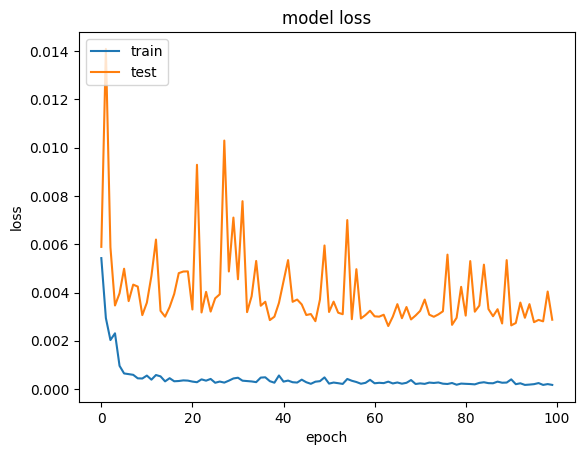

In [46]:
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
rmse = math.sqrt(mean_squared_error(y, train_prediction))
mae = mean_absolute_error(y, train_prediction)
mape = mean_absolute_percentage_error(train_prediction, y)
print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)

RMSE: 0.035650316576489496
MAE: 0.0014211155092493676
MAPE: 0.031443431133748215


# Saving the Model

In [48]:
model.save(r"C:\Users\srika\OneDrive\Desktop\DeepNet\h5\dos_attack_model.h5")

In [50]:
convert_bytes(get_file_size(r'C:\Users\srika\OneDrive\Desktop\DeepNet\h5\dos_attack_model.h5'), 'MB')

File Size is : 2.49 MB


In [51]:
# Loading the Saved Model
model1 = load_model(r'C:\Users\srika\OneDrive\Desktop\DeepNet\h5\dos_attack_model.h5')

# TF Lite Model Creation

In [53]:
converter = tf.lite.TFLiteConverter.from_keras_model(model1)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

with open(r'C:\Users\srika\OneDrive\Desktop\DeepNet\tflites\dos_attack_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\srika\AppData\Local\Temp\tmpp9oy3mxu\assets


INFO:tensorflow:Assets written to: C:\Users\srika\AppData\Local\Temp\tmpp9oy3mxu\assets


Saved artifact at 'C:\Users\srika\AppData\Local\Temp\tmpp9oy3mxu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 15, 33), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2976777174096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2976777170448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2976777173328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2976784290768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2976784292496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2976784293072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2976754286416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2976754284304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2976754284112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2976784293264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  297679751

In [55]:
convert_bytes(get_file_size(r'C:\Users\srika\OneDrive\Desktop\DeepNet\tflites\dos_attack_model.tflite'), 'KB')

File Size is : 280.12 KB


# Predicting the Model Using Tflite Model

In [58]:
interpreter = tf.lite.Interpreter(model_path=r'C:\Users\srika\OneDrive\Desktop\DeepNet\tflites\dos_attack_model.tflite')

interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

predicted_values = []
true_values = []

print(input_details)
print(output_details)

for i in range(len(X_test)):
    cnn_input_data = np.expand_dims(X_test[i], axis=0).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], cnn_input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])

    predicted_values.append(output_data[0][0])
    true_values.append(y_test[i])

predicted_values = np.array(predicted_values)
true_values = np.array(true_values)


predicted_values_reshaped = predicted_values.reshape(-1, 1)
predictions_rescaled = target_scaler.inverse_transform(predicted_values_reshaped).flatten()

y_test_reshaped = true_values.reshape(-1, 1)
y_test_rescaled = target_scaler.inverse_transform(y_test_reshaped).flatten()

results = pd.DataFrame(data={'Predictions': predictions_rescaled, 'Actuals': y_test_rescaled})
print(results)

c:\Users\srika\OneDrive\Desktop\DeepNet\env\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


[{'name': 'serving_default_input_layer_1:0', 'index': 0, 'shape': array([ 1, 15, 33], dtype=int32), 'shape_signature': array([-1, 15, 33], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall_1:0', 'index': 68, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
        Predictions  Actuals
0      1.337629e-27      0.0
1      1.860615e-22      0.0
2      5.381809e-24      0.0
3      2.247533e-24      0.0
4      1.430306e-28      0.0
...             ...      ...
22568  4.717323e-18      0.0
22569  1.101208e-17      0.0
22570  1.7

# Error Values for the Tflite Modeel

In [59]:
optimized_rmse = math.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
optimized_mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
optimized_mape = mean_absolute_percentage_error(predictions_rescaled, y_test_rescaled)

print("Optimized RMSE:", optimized_rmse)
print("Optimized MAE:", optimized_mae)
print("Optimized MAPE:", optimized_mape)

Optimized RMSE: 0.03564401723545203
Optimized MAE: 0.001417144729503424
Optimized MAPE: 0.03175381422362524
